In [1]:
from scipy.integrate import odeint 
import time
import math
import numpy as np
from math import *
import pickle as pkl
import tensorflow as tf
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
from scipy.optimize import newton
from matplotlib import animation, rc
from matplotlib import pyplot as plt

2024-10-26 15:59:51.356151: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-26 15:59:51.796779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 15:59:51.955645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 15:59:51.997082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 15:59:52.309697: I tensorflow/core/platform/cpu_feature_guar

In [3]:
m1 = 2                 # mass of pendulum 1 (in kg)
m2 = 1                # mass of pendulum 2 (in kg)
L1 = 1.4                 # length of pendulum 1 (in meter)
L2 = 1               # length of pendulum 2 (in meter)
g = 9.8                # gravitatioanl acceleration constant (m/s^2)

L1 = tf.cast(L1,dtype=tf.float32)
L2 = tf.cast(L2,dtype=tf.float32)
m1 = tf.cast(m1,dtype=tf.float32)
m2 = tf.cast(m2,dtype=tf.float32)
g = tf.cast(g,dtype=tf.float32)

In [4]:
# Differential equations describing the system
def double_pendulum(u,t,m1,m2,L1,L2,g):
    # du = derivatives
    # u = variables
    # p = parameters
    # t = time variable
    
    du = np.zeros(4)
    c = np.cos(u[0]-u[2])  # intermediate variables
    s = np.sin(u[0]-u[2])  # intermediate variables

    du[0] = u[1]   # d(theta 1)
    du[1] = ( m2*g*np.sin(u[2])*c - m2*s*(L1*c*u[1]**2 + L2*u[3]**2) - (m1+m2)*g*np.sin(u[0]) ) /( L1 *(m1+m2*s**2) )
    du[2] = u[3]   # d(theta 2)   
    du[3] = ((m1+m2)*(L1*u[1]**2*s - g*np.sin(u[2]) + g*np.sin(u[0])*c) + m2*L2*u[3]**2*s*c) / (L2 * (m1 + m2*s**2))
    
    return du

def makepath(theta1, theta2,t_final, d_t):
    u0 = [np.pi*theta1/180, 0, np.pi*theta2/180, 0]
    t = np.arange(0, t_final+d_t, d_t)
    sol = odeint(double_pendulum, u0, t, args=(m1,m2,L1,L2,g))
    return sol
    

In [102]:
sol = makepath(-14, 140, 25.01,0.01) #Caotica
#sol[:,[0,2]] = wrap_to_pi_range(sol[:,[0,2]])

In [ ]:
print(np.min(sol,0))

In [120]:
#Z scale

media = np.mean(sol,axis=0)
std = np.std(sol,axis=0)

print(media,std)

sol = (sol-media)/std

[ 0.00141303 -0.00199895 -0.03436755 -0.01510619] [0.45143937 1.35888947 1.34227109 3.36558944]


In [ ]:
input_max = (np.max(sol,axis=(0)))
input_min = (np.min(sol,axis=(0)))
#Linear scaling  (x-x_min)/(x_max-m_min) (-1,1)

print(input_min)
print(input_max)
sol = (((sol-input_min)/(input_max-input_min))-0.5)*2

tf.Tensor(0.23731565, shape=(), dtype=float32) tf.Tensor(-0.9258805, shape=(), dtype=float32)


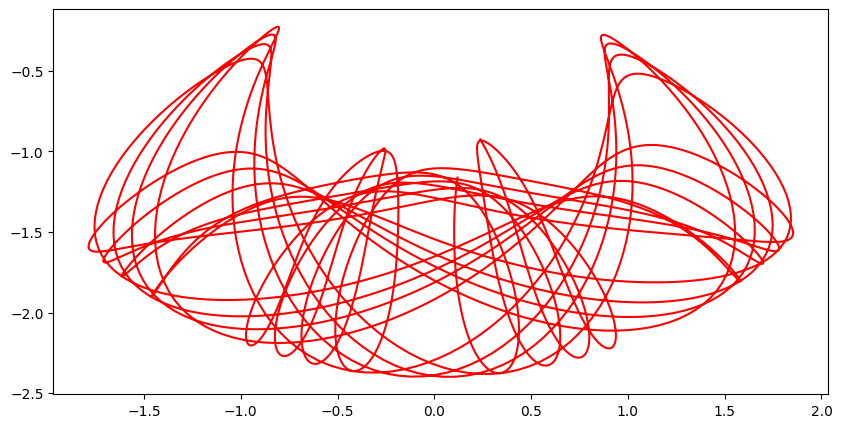

In [121]:
plt.figure(figsize=(10,5))
u0 = sol[:,0]     # theta_1 
u1 = sol[:,1]     # omega 1
u2 = sol[:,2]     # theta_2 
u3 = sol[:,3]     # omega_2 
x1 = L1*np.sin(u0);          # First Pendulum
y1 = -L1*np.cos(u0);
x2 = x1 + L2*np.sin(u2);     # Second Pendulum
y2 = y1 - L2*np.cos(u2);
vx1 = L1 * np.cos(u0) * u1
vy1 = L1 * np.sin(u0) * u1
vx2 = vx1 + L2 * np.cos(u2) * u3
vy2 = vy1 + L2 * np.sin(u2) * u3


'''solucao = np.stack((x1,vx1,y1,vy1,x2,vx2,y2,vy2),axis=1)
media = np.mean(solucao,axis=0)
std = np.std(solucao,axis=0)

print(media,std)

solucao = (solucao-media)/std'''
'''x1 = solucao[:,0]
y1 = solucao[:,2]
x2 = solucao[:,4]
y2 = solucao[:,6]'''
print(x2[0], y2[0])
plt.plot(x2[0:], y2[0:], color='r')

In [133]:
train_window = 32

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq


In [134]:
sequencias = create_inout_sequences(sol,train_window) 
inputs = tf.convert_to_tensor([sequencias[i][0] for i in range(len(sequencias))],dtype=tf.float32)
outputs = tf.reshape(tf.convert_to_tensor([sequencias[i][1] for i in range(len(sequencias))],dtype=tf.float32),(-1,4))

In [135]:
model_keras = Sequential([
    Input((train_window,4)),
    LSTM(512, return_sequences=True),
    LSTM(256, return_sequences=True),
    LSTM(128,return_sequences=False),
    Dense(4,activation="linear")])
model_keras.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 32, 512)        │     1,058,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,043,908 (7.80 MB)

 Trainable params: 2,043,908 (7.80 MB)

 Non-trainable params: 0 (0.00 B)

In [160]:
model_keras.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-6),loss="mse",metrics=["mae"])
model_keras.fit(inputs,outputs,epochs=50,batch_size=256, verbose = 2)
print("Acabou o treinamento!")

Epoch 1/50
12/12 - 1s - 101ms/step - loss: 2.9031e-07 - mae: 4.2719e-04
Epoch 2/50
12/12 - 0s - 16ms/step - loss: 2.8752e-07 - mae: 4.2551e-04
Epoch 3/50
12/12 - 0s - 17ms/step - loss: 2.8824e-07 - mae: 4.2405e-04
Epoch 4/50
12/12 - 0s - 16ms/step - loss: 2.8919e-07 - mae: 4.2673e-04
Epoch 5/50
12/12 - 0s - 16ms/step - loss: 2.9176e-07 - mae: 4.2647e-04
Epoch 6/50
12/12 - 0s - 15ms/step - loss: 2.8792e-07 - mae: 4.2479e-04
Epoch 7/50
12/12 - 0s - 16ms/step - loss: 2.9329e-07 - mae: 4.2793e-04
Epoch 8/50
12/12 - 0s - 15ms/step - loss: 2.9373e-07 - mae: 4.2906e-04
Epoch 9/50
12/12 - 0s - 15ms/step - loss: 2.9390e-07 - mae: 4.2956e-04
Epoch 10/50
12/12 - 0s - 16ms/step - loss: 2.8995e-07 - mae: 4.2616e-04
Epoch 11/50
12/12 - 0s - 15ms/step - loss: 2.9293e-07 - mae: 4.2758e-04
Epoch 12/50
12/12 - 0s - 15ms/step - loss: 2.8835e-07 - mae: 4.2522e-04
Epoch 13/50
12/12 - 0s - 16ms/step - loss: 2.9272e-07 - mae: 4.2869e-04
Epoch 14/50
12/12 - 0s - 16ms/step - loss: 2.9672e-07 - mae: 4.3020e-04


In [161]:
previsoes = inputs[0].numpy().tolist()
#previsoes = sol2[:10,:].tolist()
for i in range(2501-train_window+500):
    #(np.array([previsoes[i][:] for i in range(10*i,10*(i+1))]).reshape(-1,10,4))
    prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,4)))
    previsoes.append(prev_temp.numpy().tolist()[0])
previsoes = np.array(previsoes)

In [143]:
sol = (makepath(-14, 140, 30.0,0.01)-media)/std

In [ ]:
print(previsoes.shape)
print(sol.shape)

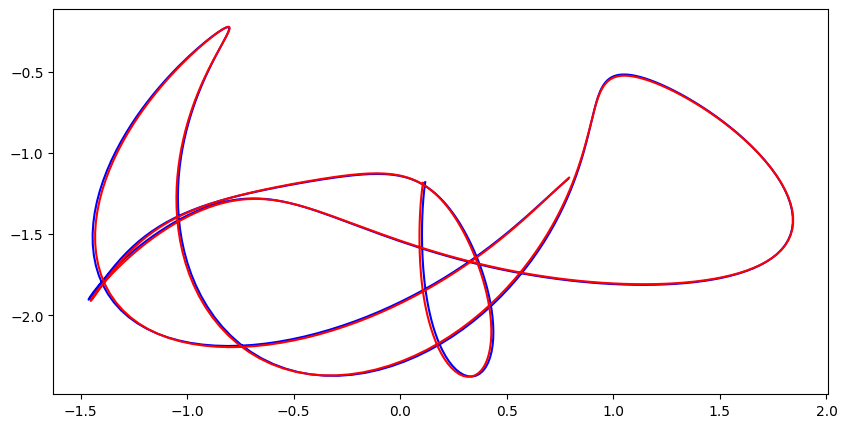

"for i in range(30):\n    n = i*100\n    m = i*100+100\n    plt.plot(x2[n:m], y2[n:m], color='b')\n    plt.plot(x2_2[n:m], y2_2[n:m], color='r')\n    plt.show()"

In [163]:
plt.figure(figsize=(10,5))
u0 = sol[:,0]     # theta_1 
u1 = sol[:,1]     # omega 1
u2 = sol[:,2]     # theta_2 
u3 = sol[:,3]     # omega_2 
x1 = L1*np.sin(u0);          # First Pendulum
y1 = -L1*np.cos(u0);
x2 = x1 + L2*np.sin(u2);     # Second Pendulum
y2 = y1 - L2*np.cos(u2);

u0_2 = previsoes[:,0]     # theta_1 
u1_2 = previsoes[:,1]     # omega 1
u2_2 = previsoes[:,2]     # theta_2 
u3_2 = previsoes[:,3]     # omega_2 
x1_2 = L1*np.sin(u0_2);          # First Pendulum
y1_2 = -L1*np.cos(u0_2);
x2_2 = x1_2 + L2*np.sin(u2_2);     # Second Pendulum
y2_2 = y1_2 - L2*np.cos(u2_2);

n,m = -500,-1

plt.plot(x2[n:m], y2[n:m], color='b')
plt.plot(x2_2[n:m], y2_2[n:m], color='r')
plt.show()

'''for i in range(30):
    n = i*100
    m = i*100+100
    plt.plot(x2[n:m], y2[n:m], color='b')
    plt.plot(x2_2[n:m], y2_2[n:m], color='r')
    plt.show()'''

In [ ]:
x1_2 = previsoes[:,0]
y1_2 = previsoes[:,2]
x2_2 = previsoes[:,4]    # Second Pendulum
y2_2 = previsoes[:,6]
n =-1
plt.plot(x2[0:n], y2[0:n], color='b')
plt.plot(x2_2[0:n], y2_2[0:n], color='r')

In [ ]:
plt.figure(figsize=(10,5))
u0 = previsoes[:,0]     # theta_1 
u1 = previsoes[:,1]     # omega 1
u2 = previsoes[:,2]     # theta_2 
u3 = previsoes[:,3]     # omega_2 
x1 = L1*np.sin(u0);          # First Pendulum
y1 = -L1*np.cos(u0);
x2 = x1 + L2*np.sin(u2);     # Second Pendulum
y2 = y1 - L2*np.cos(u2);

u0_2 = sol[:,0]     # theta_1 
u1_2 = sol[:,1]     # omega 1
u2_2 = sol[:,2]     # theta_2 
u3_2 = sol[:,3]     # omega_2 
x1_2 = L1*np.sin(u0_2);          # First Pendulum
y1_2 = -L1*np.cos(u0_2);
x2_2 = x1_2 + L2*np.sin(u2_2);     # Second Pendulum
y2_2 = y1_2 - L2*np.cos(u2_2);

n = -1
#plt.plot(x2[train_window:n], y2[train_window:n], color='b')
plt.plot(x2_2[-500:n], y2_2[-500:n], color='r')